In [ ]:
# Salary Prediction AI Project - Colab Notebook with SHAP, Fairness, Experience Curve, Heatmap

# 📌 Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# For saving model
import joblib

# 📌 Step 2: Load Dataset
url = '/content/ds_salaries.csv'
df = pd.read_csv(url)
df.dropna(inplace=True)


In [ ]:
# 📌 Step 3: Encode Categorical Columns
encoders = {}
for col in df.select_dtypes('object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

In [ ]:
# 📌 Step 4: Define Features and Target
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']

In [ ]:
# 📌 Step 5: Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 📌 Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# 📌 Step 7: Train Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [ ]:
# 📌 Step 8: Save Model
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoders, 'encoders.pkl')

['encoders.pkl']

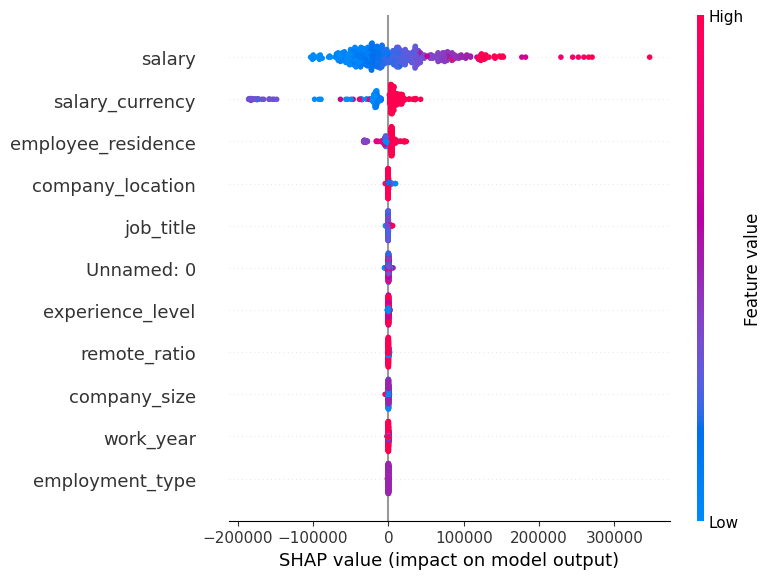

In [ ]:
# 📌 Step 9: SHAP Skill Impact Chart
explainer = shap.Explainer(model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, features=X_train, feature_names=X.columns)


In [ ]:
# 📌 Step 10: Salary Heatmap (Country-wise)
if 'employee_residence' in df.columns:
    df['employee_residence_name'] = encoders['employee_residence'].inverse_transform(df['employee_residence'])
    salary_map = df.groupby('employee_residence_name')['salary_in_usd'].mean().reset_index()
    fig = px.choropleth(salary_map,
                        locations='employee_residence_name',
                        locationmode='country names',
                        color='salary_in_usd',
                        title='Average Salary by Country',
                        color_continuous_scale='Viridis')
    fig.show()

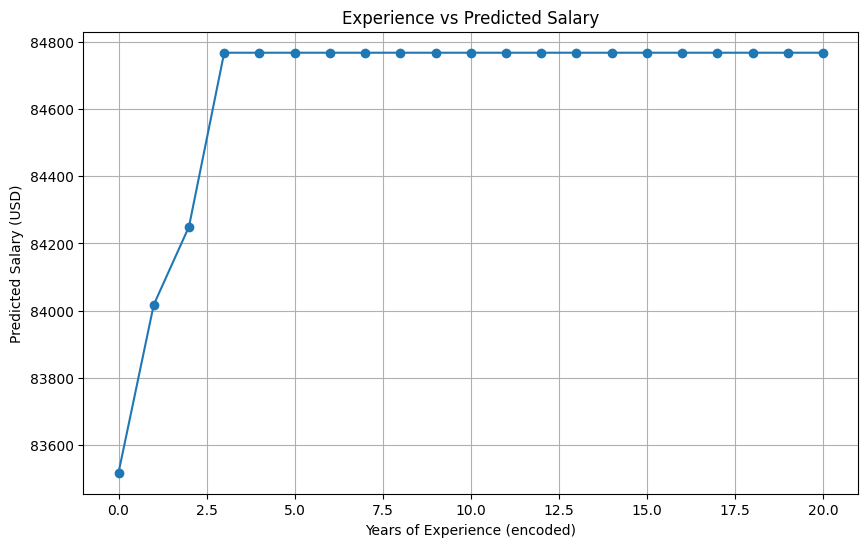

In [ ]:
# 📌 Step 11: Experience Curve Simulation
experience_values = list(range(0, 21))
avg_salary_by_exp = []
if 'experience_level' in df.columns:
    base_row = X.iloc[0].copy()
    exp_idx = X.columns.get_loc('experience_level')
    for val in experience_values:
        row = base_row.copy()
        row[exp_idx] = val
        row_scaled = scaler.transform([row])
        predicted = model.predict(row_scaled)[0]
        avg_salary_by_exp.append(predicted)

    plt.figure(figsize=(10, 6))
    plt.plot(experience_values, avg_salary_by_exp, marker='o')
    plt.title("Experience vs Predicted Salary")
    plt.xlabel("Years of Experience (encoded)")
    plt.ylabel("Predicted Salary (USD)")
    plt.grid(True)
    plt.show()

In [ ]:
# 📌 Step 12: Fairness Check (Urban vs Rural)
if 'remote_ratio' in df.columns:
    df['remote_type'] = pd.cut(df['remote_ratio'], bins=[-1, 0, 50, 100], labels=['Office', 'Hybrid', 'Remote'])
    fairness = df.groupby('remote_type')['salary_in_usd'].mean()
    print("\nFairness Analysis (Remote Setting vs Salary):\n", fairness)


Fairness Analysis (Remote Setting vs Salary):
 remote_type
Office    106354.622047
Hybrid     80823.030303
Remote    122457.454068
Name: salary_in_usd, dtype: float64


In [ ]:
# 📌 Step 13: Resume Upload (Optional - NLP)
# You can integrate PyMuPDF, spaCy, or Transformers here in the web app separately.

# Example:
# import spacy
# nlp = spacy.load("en_core_web_sm")
# text = "Resume text here"
# doc = nlp(text)
# skills = [ent.text for ent in doc.ents if ent.label_ == "SKILL"]

In [ ]:
# Install necessary packages
!pip install flask scikit-learn joblib numpy pandas flask-cors

In [ ]:
!pip install flask-ngrok

In [ ]:
!pip install flask-ngrok flask-cors joblib


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ds_salaries.csv to ds_salaries (1).csv


In [ ]:
!pip install shap scikit-learn pandas joblib matplotlib


In [ ]:
!pip install flask-cors

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install flask flask-ngrok streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.8 MB/s eta 0:00:00


**Export Processed Data as JSON**

In [ ]:
experience_salary = df.groupby('experience_level')['salary_in_usd'].mean().reset_index()
experience_salary.columns = ['experience_level', 'average_salary']
experience_salary.to_json("experience_curve.json", orient="records")


In [ ]:
country_salary = df.groupby('company_location')['salary_in_usd'].mean().reset_index()
country_salary.columns = ['country', 'average_salary']
country_salary.to_json("country_salary.json", orient="records")


In [ ]:
fairness = df.groupby('employee_residence')['salary_in_usd'].mean().reset_index()
fairness.columns = ['region', 'avg_salary']
fairness.to_json("fairness_stats.json", orient="records")


**Outlier Removal Using Z-Score**

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Load your dataset
df = pd.read_csv('/content/ds_salaries.csv')

# Apply z-score only to numeric columns
numeric_cols = df.select_dtypes(include=np.number)

# Calculate z-scores
z_scores = np.abs(zscore(numeric_cols))

# Filter out rows with any z-score > 3
df_cleaned = df[(z_scores < 3).all(axis=1)]

# Display result
print(f"Original rows: {len(df)}")
print(f"Cleaned rows: {len(df_cleaned)}")


Original rows: 607
Cleaned rows: 591


*** Model Comparison (RandomForest vs LinearRegression):***

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

models = {
    "RandomForest": RandomForestRegressor(),
    "LinearRegression": LinearRegression()
}

for name, m in models.items():
    m.fit(X_train, y_train)
    preds = m.predict(X_test)
    print(f"{name} → MAE: {mean_absolute_error(y_test, preds):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}, R2: {r2_score(y_test, preds):.2f}")

RandomForest → MAE: 28635.38, RMSE: 42387.32, R2: 0.53
LinearRegression → MAE: 35366.61, RMSE: 50585.85, R2: 0.33


**Salary Heatmap by Country**


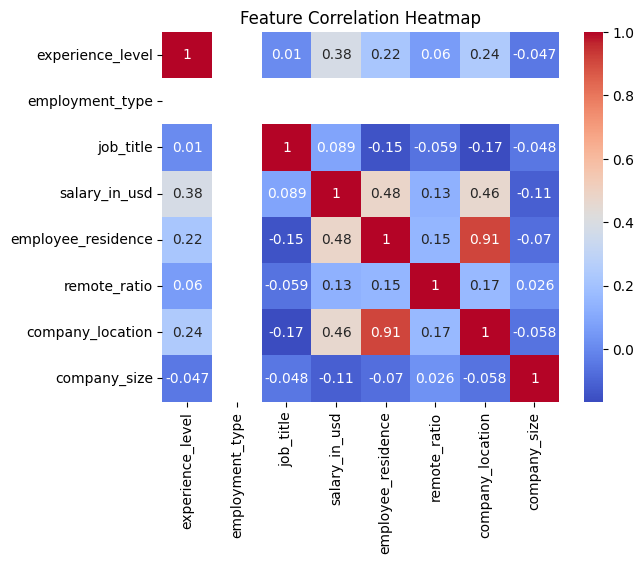

In [ ]:
# Heatmap
numeric_df = df.drop(['Unnamed: 0', 'work_year', 'salary', 'salary_currency'], axis=1)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


**Visualize Decision Tree**

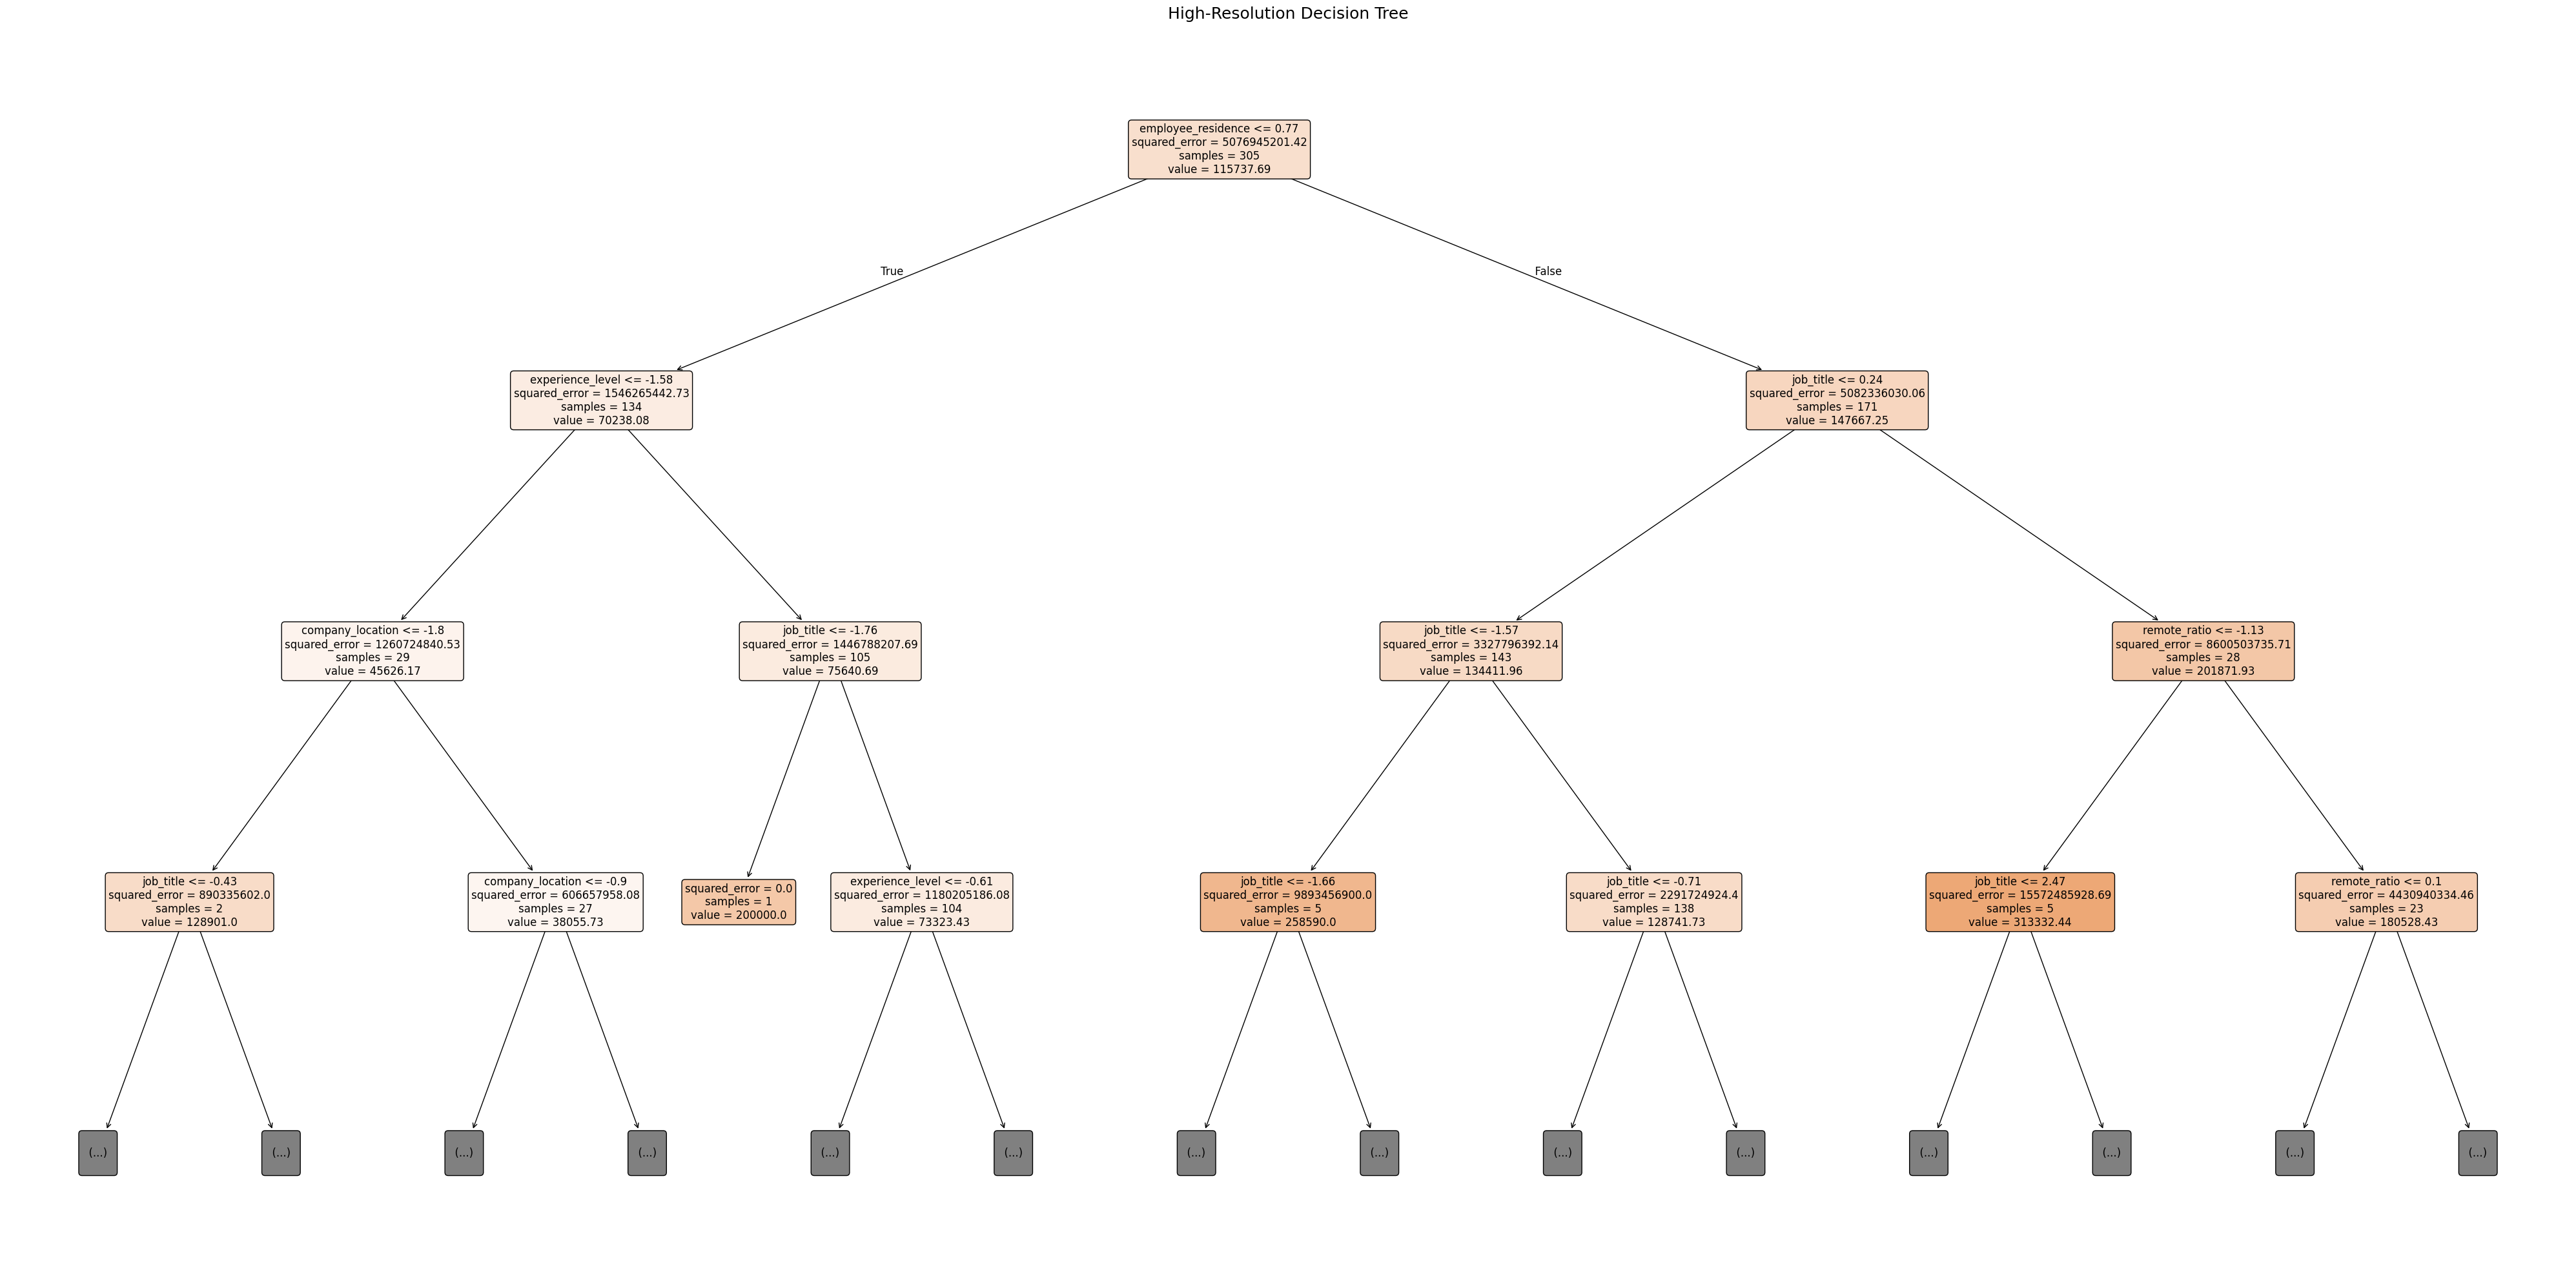

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# Extract one tree from the forest
single_tree = model.estimators_[0]

# Plot with improved layout
fig, ax = plt.subplots(figsize=(40, 20))  # Wider canvas
tree.plot_tree(
    single_tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=12,
    impurity=True,       # Show impurity (optional)
    precision=2          # Round float values
)
plt.title("High-Resolution Decision Tree", fontsize=18)
plt.tight_layout()
fig.savefig("high_res_tree.pdf", bbox_inches='tight')  # Save as PDF
plt.show()


**Reload Model and Encoders (for Deployment)**

In [ ]:
import joblib
model = joblib.load("model.pkl")
scaler = joblib.load("scaler.pkl")
encoders = joblib.load("encoders.pkl")


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

# Load dataset
df = pd.read_csv('/content/ds_salaries.csv')
df.drop(['salary', 'salary_currency'], axis=1, inplace=True)

# Encode categorical features
encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

# Train-test split
X = df.drop('salary_in_usd', axis=1)
y = df['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestRegressor()
model.fit(X_train_scaled, y_train)

# Save artifacts
joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoders, 'encoders.pkl')


['encoders.pkl']

**Prepare Training and Save Again (Redundant)**

In [ ]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoders, 'encoders.pkl')


['encoders.pkl']

**Add ngrok Token (For Tunnel)**

In [ ]:
!ngrok config add-authtoken 303pUHw4QeaPPT8ti0FBCo6sKhp_6R7CyNNKFPNK1h17M2yZk

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
